<a href="https://colab.research.google.com/github/G-Assimila/pvlncc2025/blob/main/notebooks/Escola_VeraoLNCC_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Workshop da Escola de Verão do Laboratório Nacional de Computação Científica (LNCC)

###Mini-curso: Assimilação de Dados por Aprendizado de Máquina


####Neste notebook iremos desenvolver um modelo de Assimilação de Dados de Temperautua baseado em Aprendizado de Máquina.

####Para isso, carregaremos um conjunto de dados de observação e treinaremos um algoritmo baseado em Árvores de Decisão e *Boosting*, uma técnica baseada em aprendizado por *ensemble*.

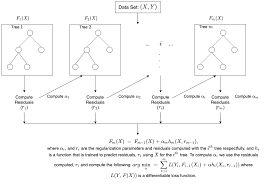





##Instalações necessárias

In [ ]:
!pip install cartopy

##Importações dos pacotes necessários

In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import signal
import cartopy.crs as ccrs
from sklearn.utils import shuffle
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors
from sklearn.metrics import mean_squared_error

##Funções auxiliares

In [ ]:
def expand(dataframe, coluna, variavel):
  result = {}
  for i in dataframe[variavel].unique():
    coluna_resutl = dataframe.loc[dataframe[variavel] == i][coluna].to_numpy()
    result[int(i)] = coluna_resutl

  return result

def plot(longi, lat, data, title, x=(-58.9,-47.699), y=(-36.2,-25.1),
         figsize=(10,8.5)):

    fig = plt.figure(figsize=figsize)

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())

    # Make a filled contour plot
    cs=ax.contourf(longi.T, lat.T, data.T,
                transform = ccrs.PlateCarree(),cmap='jet',extend='both')

    ax.coastlines()
    states = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_0_boundary_lines_land', #admin_1_states_provinces - admin_0_boundary_lines_land
                scale='10m',
                facecolor='none',
                edgecolor='black')

    cbar = plt.colorbar(cs,shrink=0.5,orientation='vertical',
                        label='Temperatura 2M')
    ax.add_feature(states, linewidth=2, edgecolor="black")
    ax.add_feature(cfeature.LAND)

    ax.set_xlim(x)
    ax.set_ylim(y)
    ax.coastlines()
    ax.set_title(title)

##Download dos dados

In [ ]:
!gdown https://drive.google.com/uc?id=1_RHG_Gos-EDP5w0CoNXlrWDXsawtN9br
!gdown https://drive.google.com/uc?id=1KnMf7PMn8ZTZfD0-HF8BjoMltZS4l5Bw

Downloading...
From (original): https://drive.google.com/uc?id=1_RHG_Gos-EDP5w0CoNXlrWDXsawtN9br
From (redirected): https://drive.google.com/uc?id=1_RHG_Gos-EDP5w0CoNXlrWDXsawtN9br&confirm=t&uuid=8d302965-b96d-4eb9-a450-9eb9c18e83f0
To: /content/test.csv
100% 183M/183M [00:01<00:00, 126MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1KnMf7PMn8ZTZfD0-HF8BjoMltZS4l5Bw
From (redirected): https://drive.google.com/uc?id=1KnMf7PMn8ZTZfD0-HF8BjoMltZS4l5Bw&confirm=t&uuid=abf6396a-dd5e-4a04-ba69-2e63fe6da996
To: /content/train.csv
100% 177M/177M [00:01<00:00, 101MB/s]


##Lendo conjuntos de treino e teste

In [ ]:
PATH="/content/"

#treino
df_train = pd.read_csv(PATH+'train.csv', header=0)
df_train = df_train.drop(columns=['Unnamed: 0'], axis=1)

#teste
df_test = pd.read_csv(PATH+'test.csv', header=0)
df_test = df_test.drop(columns=['Unnamed: 0'], axis=1)

print(df_train.shape)
print(df_test.shape)

(1577928, 10)
(1649652, 10)


In [ ]:
df_train.head()

,LAT,LONG,PONTO DE GRADE Y,PONTO DE GRADE X,VAL. SIMULACAO,VALOR DE OBSERVACAO,ANO,TARGET,MES,DIA
0,-36.198620,-59.649200,1.0,1.0,289.802551,289.802551,2017,289.33725,7,28
1,-36.202236,-59.549255,1.0,2.0,289.662781,289.662781,2017,289.26273,7,28
2,-36.205776,-59.449310,1.0,3.0,289.448120,289.448120,2017,289.05374,7,28
3,-36.209244,-59.349365,1.0,4.0,289.283569,289.283569,2017,288.91327,7,28
4,-36.212631,-59.249420,1.0,5.0,289.022247,291.700010,2017,288.60556,7,28


### Valores de Latitude e Longitude, Mês e Ano

In [ ]:
df_train['LAT'].min(), df_train['LAT'].max()

(-36.28812026977539, -24.93133544921875)

In [ ]:
df_train['LONG'].min(), df_train['LONG'].max()

(-59.649200439453125, -46.849456787109375)

In [ ]:
df_train['MES'].unique(), df_train['ANO'].unique()

(array([7, 6, 8]), array([2017]))

In [ ]:
df_test['MES'].unique(), df_test['ANO'].unique()

(array([8, 7, 6]), array([2018]))

### visualização dos dados

#### a grade estudada tem dimensões 129x139, totalizando 17931 pontos

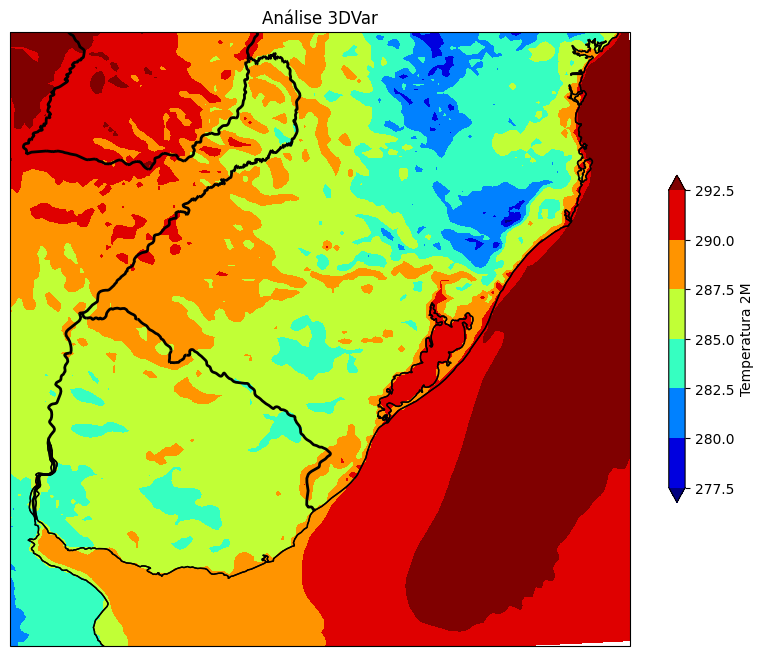

In [ ]:
ativacao_dia_teste = df_train[(df_train['MES'] == 7) & (df_train['DIA'] == 6)]

lat = expand(ativacao_dia_teste, 'LAT', variavel='PONTO DE GRADE Y')
lat = pd.DataFrame(lat)

longi = expand(ativacao_dia_teste, 'LONG', variavel='PONTO DE GRADE Y')
longi = pd.DataFrame(longi)

rotulos = expand(ativacao_dia_teste, 'TARGET', variavel='PONTO DE GRADE Y')
rotulos = pd.DataFrame(rotulos)

plot(longi, lat, rotulos, 'Análise 3DVar', x=(-58.9,-47.699), y=(-36.2,-25.1),
     figsize=(10,8.5))

##Conjunto de treino e validação

In [ ]:
df_val = df_train[df_train['MES'] == 8]
df_train = df_train[df_train['MES'] <= 7]

In [ ]:
y_train = df_train['TARGET'].copy()
X_train = df_train[['LAT', 'LONG', 'PONTO DE GRADE Y', 'PONTO DE GRADE X',
                    'VAL. SIMULACAO', 'VALOR DE OBSERVACAO', 'MES', 'DIA']].copy()
X_train.head()

,LAT,LONG,PONTO DE GRADE Y,PONTO DE GRADE X,VAL. SIMULACAO,VALOR DE OBSERVACAO,MES,DIA
0,-36.198620,-59.649200,1.0,1.0,289.802551,289.802551,7,28
1,-36.202236,-59.549255,1.0,2.0,289.662781,289.662781,7,28
2,-36.205776,-59.449310,1.0,3.0,289.448120,289.448120,7,28
3,-36.209244,-59.349365,1.0,4.0,289.283569,289.283569,7,28
4,-36.212631,-59.249420,1.0,5.0,289.022247,291.700010,7,28


In [ ]:
y_val = df_val['TARGET'].copy()
X_val = df_val[['LAT', 'LONG', 'PONTO DE GRADE Y', 'PONTO DE GRADE X',
                    'VAL. SIMULACAO', 'VALOR DE OBSERVACAO', 'MES', 'DIA']].copy()
X_val.head()

,LAT,LONG,PONTO DE GRADE Y,PONTO DE GRADE X,VAL. SIMULACAO,VALOR DE OBSERVACAO,MES,DIA
107586,-36.198620,-59.649200,1.0,1.0,285.153107,285.153107,8,18
107587,-36.202236,-59.549255,1.0,2.0,285.132874,285.132874,8,18
107588,-36.205776,-59.449310,1.0,3.0,285.079285,285.079285,8,18
107589,-36.209244,-59.349365,1.0,4.0,285.012360,285.012360,8,18
107590,-36.212631,-59.249420,1.0,5.0,284.995575,286.799990,8,18


##Conjunto de teste

In [ ]:
y_test = df_test['TARGET'].copy()
X_test = df_test[['LAT', 'LONG', 'PONTO DE GRADE Y', 'PONTO DE GRADE X',
                    'VAL. SIMULACAO', 'VALOR DE OBSERVACAO', 'MES', 'DIA']].copy()
X_test.head()

,LAT,LONG,PONTO DE GRADE Y,PONTO DE GRADE X,VAL. SIMULACAO,VALOR DE OBSERVACAO,MES,DIA
0,-36.198620,-59.649200,1.0,1.0,280.371643,280.371643,8,16
1,-36.202236,-59.549255,1.0,2.0,280.334778,280.334778,8,16
2,-36.205776,-59.449310,1.0,3.0,280.300171,280.300171,8,16
3,-36.209244,-59.349365,1.0,4.0,280.277283,280.277283,8,16
4,-36.212631,-59.249420,1.0,5.0,280.279175,281.399990,8,16


###Treinamento do algoritmo -  XGBoost



In [ ]:
my_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators = 500,
                            max_depth = 5, early_stopping_rounds=10)

evalset = [(X_train[['VALOR DE OBSERVACAO']].values,
            y_train.values),
           (X_val[['VALOR DE OBSERVACAO']].values,
            y_val.values)]

trained_model = my_model.fit(X_train[['VALOR DE OBSERVACAO']].values,
                             y_train.values,
            eval_set=evalset, verbose=True)


[0]	validation_0-rmse:3.37976	validation_1-rmse:3.25282
[1]	validation_0-rmse:2.38919	validation_1-rmse:2.30084
[2]	validation_0-rmse:1.70365	validation_1-rmse:1.64133
[3]	validation_0-rmse:1.23529	validation_1-rmse:1.19124
[4]	validation_0-rmse:0.92220	validation_1-rmse:0.89129
[5]	validation_0-rmse:0.72035	validation_1-rmse:0.69814
[6]	validation_0-rmse:0.59684	validation_1-rmse:0.58051
[7]	validation_0-rmse:0.52570	validation_1-rmse:0.51318
[8]	validation_0-rmse:0.48703	validation_1-rmse:0.47697
[9]	validation_0-rmse:0.46687	validation_1-rmse:0.45826
[10]	validation_0-rmse:0.45662	validation_1-rmse:0.44880
[11]	validation_0-rmse:0.45148	validation_1-rmse:0.44411
[12]	validation_0-rmse:0.44889	validation_1-rmse:0.44180
[13]	validation_0-rmse:0.44758	validation_1-rmse:0.44064
[14]	validation_0-rmse:0.44691	validation_1-rmse:0.44006
[15]	validation_0-rmse:0.44654	validation_1-rmse:0.43977
[16]	validation_0-rmse:0.44634	validation_1-rmse:0.43960
[17]	validation_0-rmse:0.44619	validation

In [ ]:
preds = trained_model.predict(X_test[['VALOR DE OBSERVACAO']].values)
mse_test = mean_squared_error(y_test, preds)
print(f'Test MSE: {mse_test}')

Test MSE: 0.25278043159465735


In [ ]:
#grava os resultados no arquivo .csv
results_model = X_test.copy()
results_model['target'] = y_test
results_model['predictions'] = preds
results_model.head()

,LAT,LONG,PONTO DE GRADE Y,PONTO DE GRADE X,VAL. SIMULACAO,VALOR DE OBSERVACAO,MES,DIA,target,predictions
0,-36.198620,-59.649200,1.0,1.0,280.371643,280.371643,8,16,279.86060,280.361847
1,-36.202236,-59.549255,1.0,2.0,280.334778,280.334778,8,16,279.85074,280.361847
2,-36.205776,-59.449310,1.0,3.0,280.300171,280.300171,8,16,279.83188,280.257935
3,-36.209244,-59.349365,1.0,4.0,280.277283,280.277283,8,16,279.81973,280.257935
4,-36.212631,-59.249420,1.0,5.0,280.279175,281.399990,8,16,279.79227,281.320618


In [ ]:
#results_model.to_csv('results.csv')

##Visualização dos resultados

In [ ]:
ativacao_dia_teste = results_model[(results_model['MES'] == 7) & (results_model['DIA'] == 6)]
ativacao_dia_teste.shape

(17931, 10)

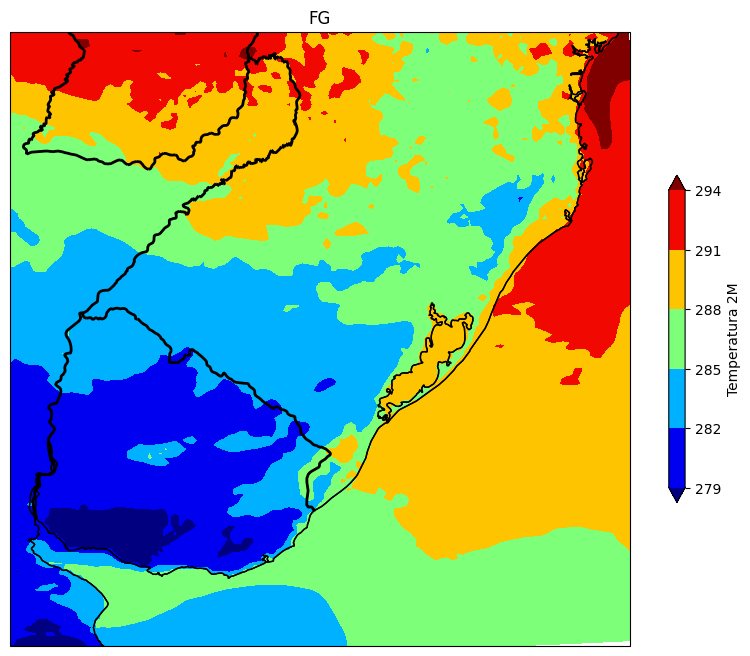

In [ ]:
fg = expand(ativacao_dia_teste, 'VAL. SIMULACAO', variavel='PONTO DE GRADE Y')
fg = pd.DataFrame(fg)

plot(longi, lat, fg, 'FG', x=(-58.9,-47.699), y=(-36.2,-25.1),
     figsize=(10,8.5))

In [ ]:
lat = expand(ativacao_dia_teste, 'LAT', variavel='PONTO DE GRADE Y')
lat = pd.DataFrame(lat)

longi = expand(ativacao_dia_teste, 'LONG', variavel='PONTO DE GRADE Y')
longi = pd.DataFrame(longi)

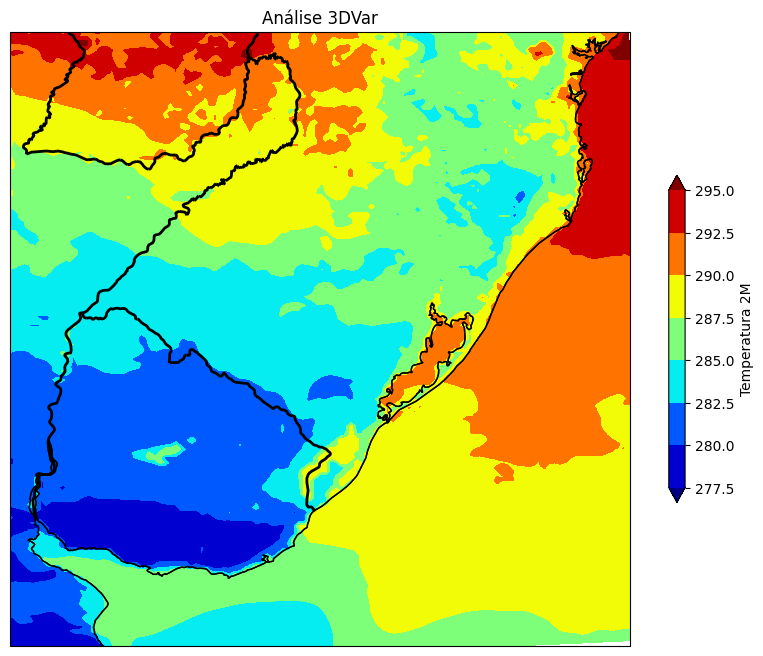

In [ ]:
rotulos = expand(ativacao_dia_teste, 'target', variavel='PONTO DE GRADE Y')
rotulos = pd.DataFrame(rotulos)

plot(longi, lat, rotulos, 'Análise 3DVar', x=(-58.9,-47.699), y=(-36.2,-25.1),
     figsize=(10,8.5))

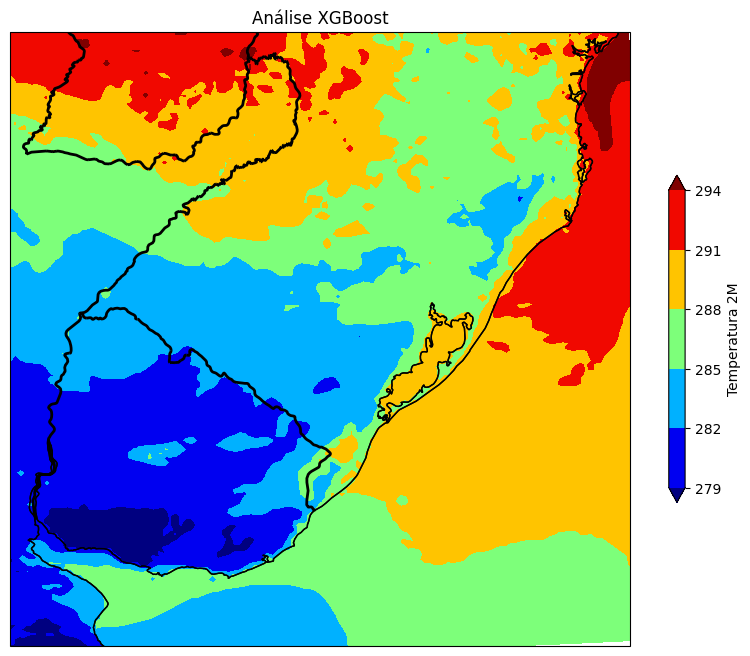

In [ ]:
preds = expand(ativacao_dia_teste, 'predictions', variavel='PONTO DE GRADE Y')
preds = pd.DataFrame(preds)

plot(longi, lat, preds, 'Análise XGBoost', x=(-58.9,-47.699), y=(-36.2,-25.1),
     figsize=(10,8.5))

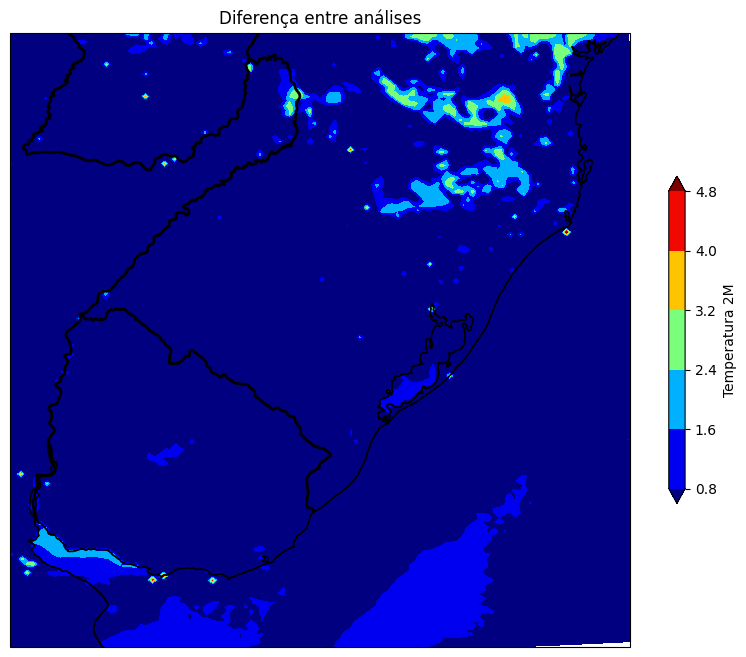

In [ ]:
plot(longi, lat, abs(preds-rotulos), 'Diferença entre análises', x=(-58.9,-47.699), y=(-36.2,-25.1),
     figsize=(10,8.5))